# Group name 4295

Name

Chenyu Sun (z5534688)

Shizhuang Liu (z5532219)

Yuzhe Zheng (z5622749)

Kai Wu (z5511490)

Ting Liu (z5568837)


# Table Content

1. [Introduction & Motivation](#section-1)
2. [Data Source](#section-2)
3. [Exploratory Analysis of Data](#section-3)
4. [Baseline Models](#section-4)
5. [Project Model](#section-5)
6. [Project Code](#section-6)
7. [Result](#section-7)
8. [Analysis](#section-8)

# <a name="section-1"></a>Introduction & Motivation

Insect pests pose a significant threat to global agriculture. For example, insect pests may cause widespread crop damage, which leads to a decrease in yield and quality and results in substantial economic losses and contributing to food insecurity. However, traditional manual methods for pest identification are often slow, error-prone, and impractical for large-scale agricultural applications, especially under complex species diversity and varying environmental conditions. Therefore, there is an urgent need for more advanced solutions. For example, rapid and accurate identification of insect pests is critical for effective pest management and timely intervention. The objective of this project is to develop an Deep learning-based automated system for insect pest classification. To be effective, we must meet two essential requirements: high accuracy and strong robustness to environmental and visual variability. Obviously, the aim of this project is to improve pest classification by applying Swin-ResNet Combined Model that is a lightweight and efficient model with state-of-the-art performance on visual tasks.

# <a name="section-2"></a>Data Source

The IP102 dataset is a benchmark dataset for insect pests.

The details about the dataset can be found in the github  
https://github.com/xpwu95/IP102/tree/master

Download URL: https://drive.google.com/drive/folders/1svFSy2Da3cVMvekBwe13mzyx38XZ9xWo


# <a name="section-3"></a>Exploratory Analysis of Data

The IP102 datset contains more than 75,000 images belongs to 102 categories. A natural long-tailed distribution presents on it. In addition, 19,000 images are annotated with bounding boxes for object detection. Also, the distribution of images is highly imbalanced.

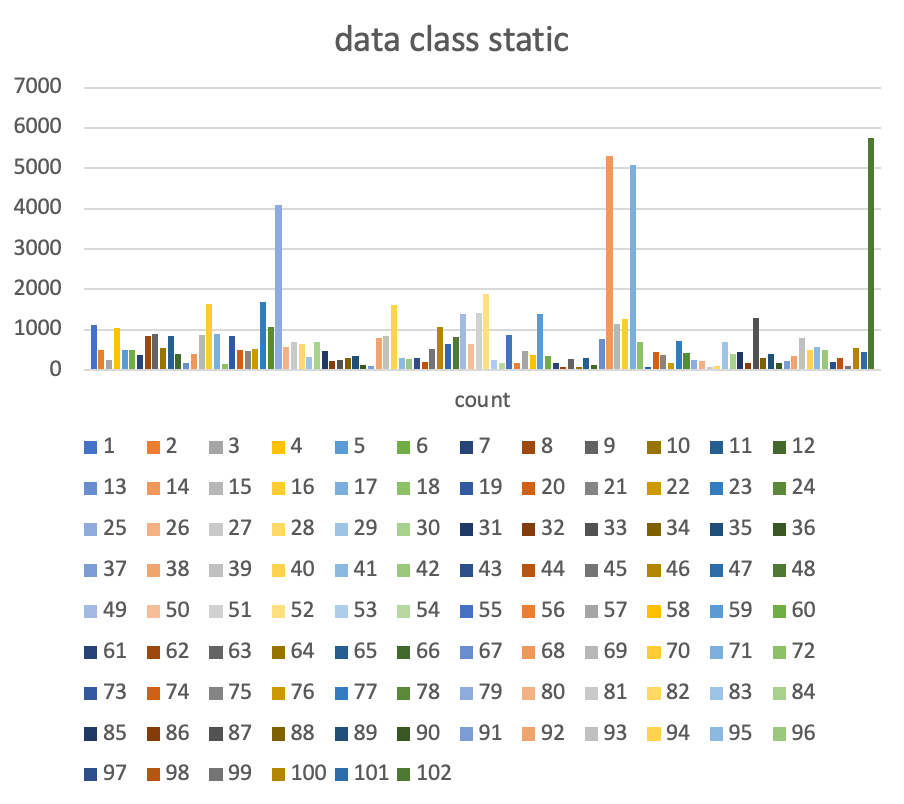

According to the distribution map of insect pest species, it can be seen that the class distribution is hight imbalanced.   Nevertheless, the dataset divides the images of each species into training, validation, and test sets to facilitate researchers' use.

## Data characteristics and challenges

### Long-tailed distribution

A few head categories can have thousands of samples, while tail categories only have tens of samples, model training is easily biased towards multi-sample categories, making it difficult to learn features of few-sample categories

### Environmental diversity

The images are taken from natural fields, and the background contains many kinds of disturbances, such as soil, leaves, and agricultural tools; the lighting, viewing angle, and pose vary greatly, which tests the robustness of the model.

### Fine-grained similarity


Many closely related species (e.g., differently colored borers, stinging mite families) are very similar in appearance. Additionally, the same pests also differ significantly in larval and adult stages, requiring models with the ability to discriminate fine features.

# <a name="section-4"></a>Baseline Models

## MobileNet-v2

MobileNet-v2(https://pytorch.org/hub/pytorch_vision_mobilenet_v2/) is a lightweight Convolutional Neural Network (CNN) designed by Google researchers in 2018 for mobile and embedded devices.MobileNet-v2 is a convolutional neural network that is 53 layers deep.
The architecture is as follows:
- Input: 224x224 RGB image.
- Initial Layer: 3x3 standard convolution (stride 2), outputting 32 channels.
- Main Body: 17 inverted residual blocks with expansion, depthwise separable convolution, and projection operations, some with shortcut connections.
- Output: Global average pooling + fully connected layer for classification.

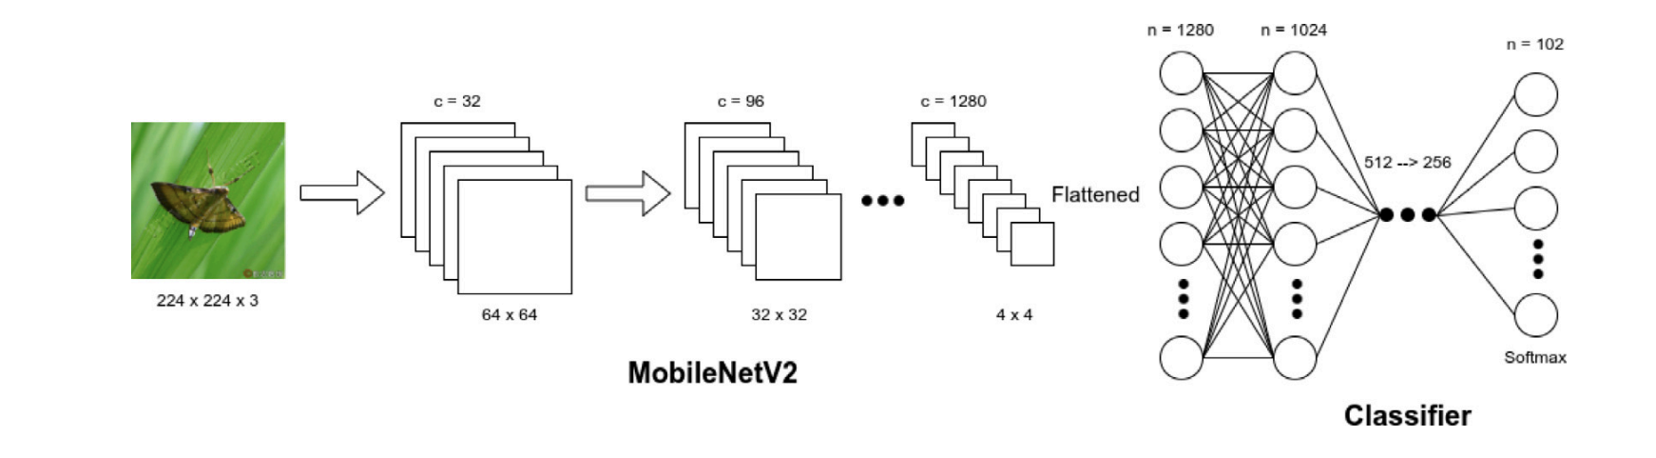

## Swin-Tiny Transformer


The Swin-Tiny(https://github.com/microsoft/Swin-Transformer) Model is a variant of the Swin Transformer, a hierarchical vision transformer designed for computer vision tasks. It uses a shifted window-based self-attention mechanism to efficiently capture local and global features in images. Here is the architecture:

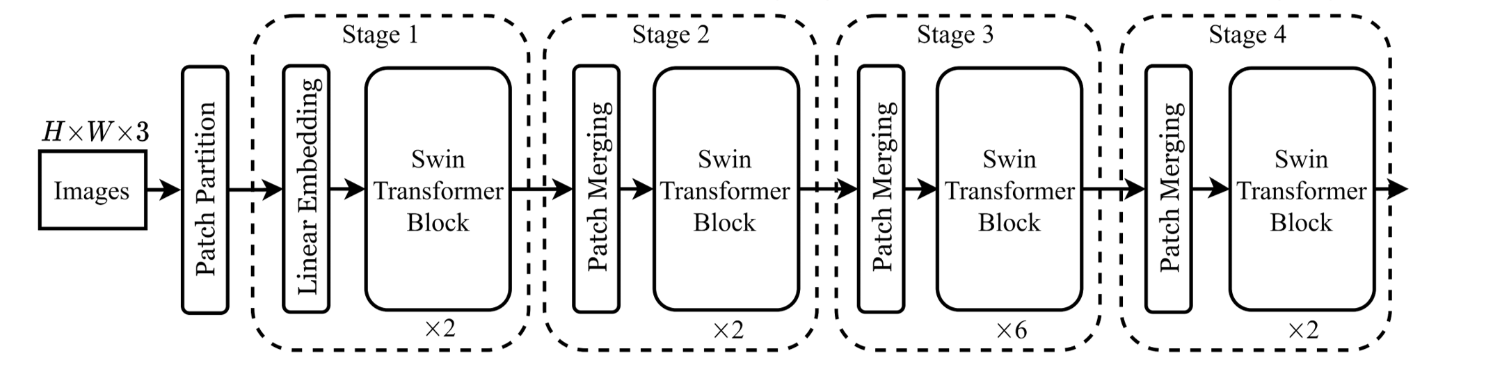

## ResNet-50


ResNet-50(https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html) is CNN architecture that belongs to the ResNet (Residual Networks) family, a series of models designed to address the challenges associated with training deep neural networks. In this projcetm the model was pretrained by Image Here is the architecture





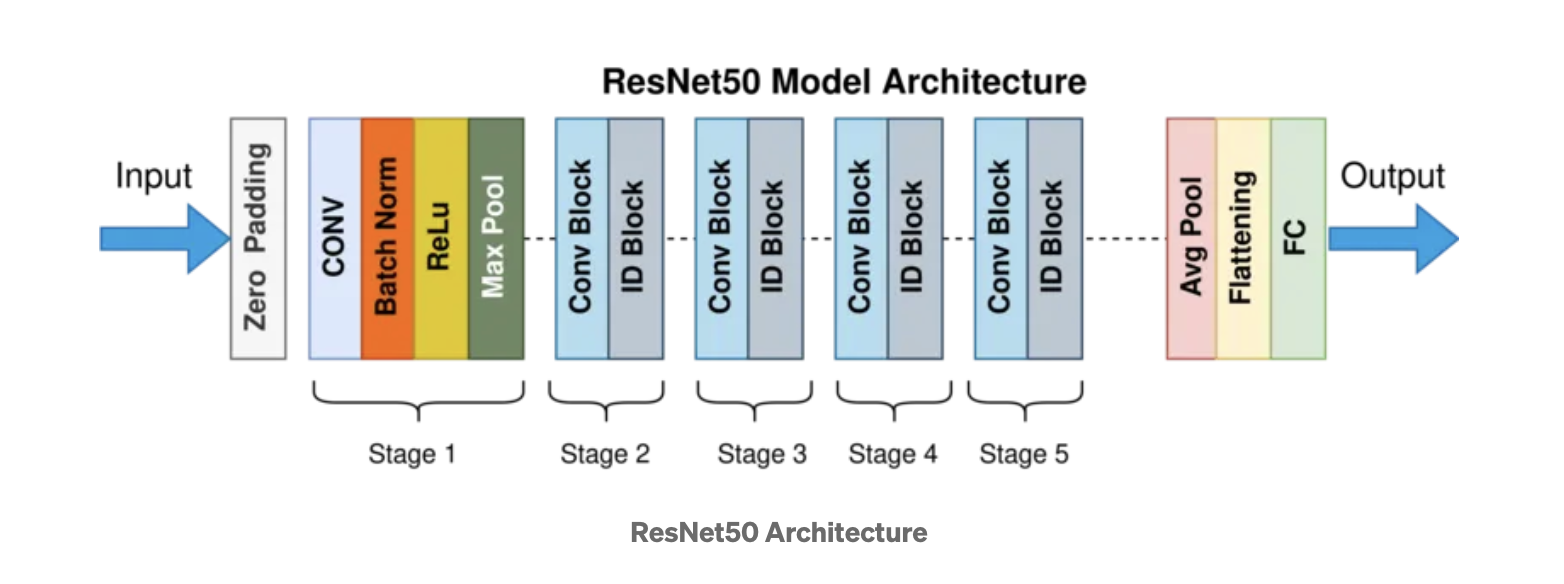

## Comparision for Baseline Models


We compare five metrics with three baseline models.


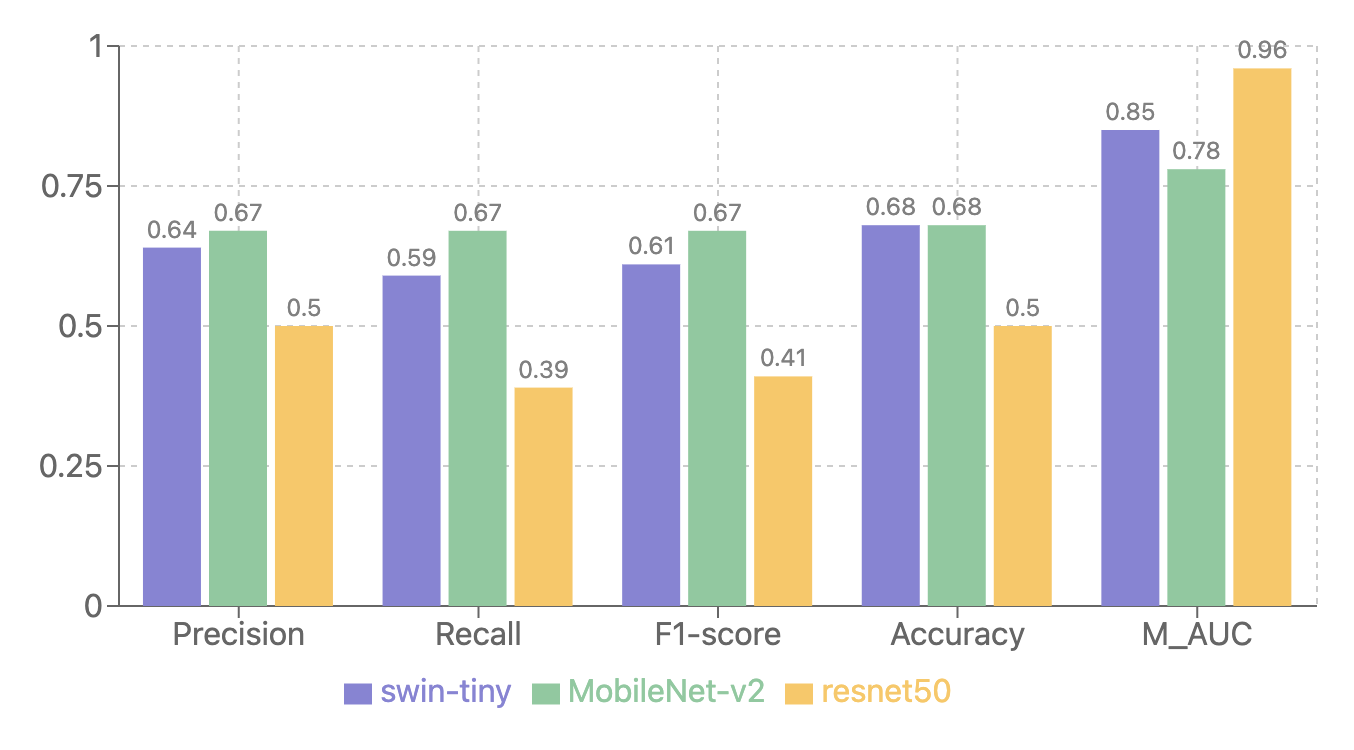

Swin-tiny
- Great global modeling for medium to high sample classes
- Weaker on small samples

MobileNet-v2
- Balance performance
- Less misclassification in small sample classes
- Struggle with local features in complex backgrounds.

ResNet-50
- Captures fine details
- Overfits on small sample classes
- Poor understanding of sample relationships.

# <a name="section-5"></a>Poject Model

## Model Inroduction

SwinResNetCombined is a hybrid backbone network model for the IP102 pest image classification task. It merges two classical visual backbones in parallel: Swin Transformer, which is based on hierarchical window self-attention, and ResNet-50, which is good at extracting local texture and edge features, to capture global structural information and microscopic details simultaneously. After linear mapping alignment, the two features are spliced along the channel dimensions to jointly discriminate 102 fine-grained pest classes by a fully connected classification header.

The SwinResNetCombined model integrates Swin Transformer and ResNet-50 through the following steps:

* Parallel extraction of features from Swin (1024 dimensions) and ResNet (2048 dimensions).
* Projection of ResNet features to 1024 dimensions using a linear layer to align with Swin features.
* Concatenation of both feature sets along the feature dimension to form a 2048-dimensional fused feature vector.
* Mapping of the fused features to 102 dimensions via a fully connected layer for classification.

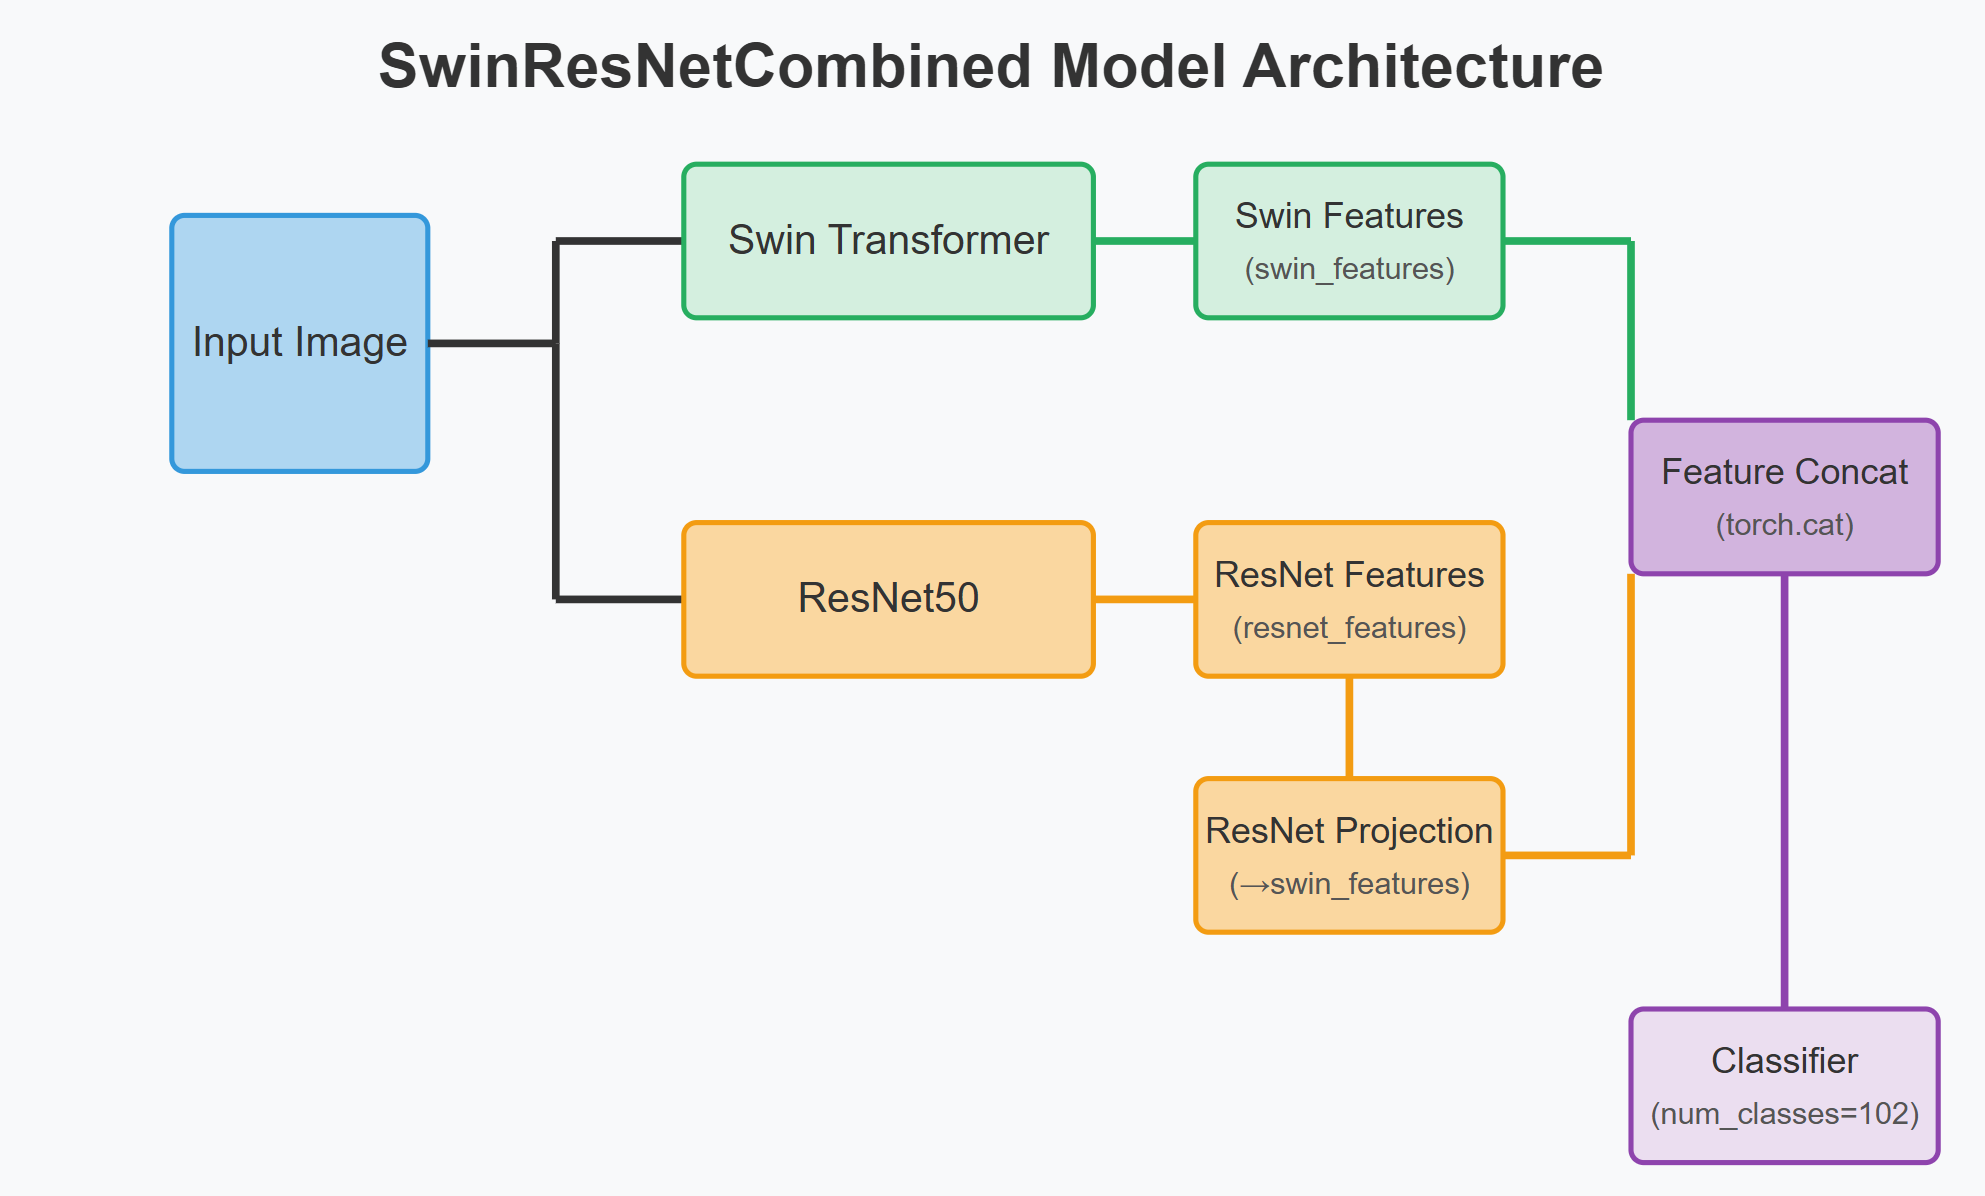

## Typical Pre-processing

### Resize & crop

RandomResizedCrop to 224×224 pixels (to match Swin/ResNet input)

In [ ]:
transforms.RandomResizedCrop(224)

### Data augmentation

1.   Random horizontal/vertical flips
2.   Random rotations
3.   Color jitter (brightness/contrast/saturation)





In [ ]:
transforms.RandomHorizontalFlip(),
transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
transforms.ToTensor(),

### Normalization

Convert to tensor and normalize using ImageNet statistics

In [ ]:
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

## Learning from previous work and sources

### Calling timm.create_model


In [ ]:
self.swin   = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=0)
self.resnet = timm.create_model('resnet50',                     pretrained=True, num_classes=0)


### Optimizer & Scheduler

*   AdamW with weight decay: standard for vision transformers and CNNs (Loshchilov & Hutter, ICLR 2019).

*   Linear warmup → CosineAnnealingLR: common best practice for stabilizing transformer training.



In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.05)

## Custom Implementation

### Building SwinResNetCombined architecture


In [ ]:
swin_features = self.swin.num_features
resnet_features = self.resnet.num_features
self.resnet_proj = nn.Linear(resnet_features, swin_features)
self.classifier = nn.Linear(swin_features * 2, num_classes)

*   Parallel forward-pass through two distinct backbones.




*   Linear mapping to align ResNet feature dimension with Swin’s output.


*   Feature‐level fusion via concatenation, followed by a unified classification layer.






### Training loop orchestration

*   Custom logging every 100 batches
*   Validation‐based checkpointing
*   Visualization of results



# <a name="section-6"></a>Project code

In [ ]:
import zipfile
import torch
import torch.nn as nn
import gc
import zipfile
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
from tqdm import tqdm
import timm
from PIL import Image
from torch.utils.data import Dataset
from accelerate import Accelerator
accelerator = Accelerator()
import pandas as pd
import numpy as np


print("Completed")

Completed


In [ ]:
# connect to google drive and get dataset
from google.colab import drive
drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/9444/IP102.zip'
extraction_path = '/content/data'

os.makedirs(extraction_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"successfully unzip '{os.path.basename(zip_file_path)}' to '{extraction_path}'")


Mounted at /content/drive
successfully unzip 'IP102.zip' to '/content/data'


In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, list_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        with open(list_file, 'r') as f:
            for line in f:
                img_name, label = line.strip().split()
                img_path = os.path.join(root_dir, img_name)
                self.samples.append((img_path, int(label)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
data_root = '/content/data/IP102'
image_dir = os.path.join(data_root, 'images')
train_list = os.path.join(data_root, 'train.txt')
val_list = os.path.join(data_root, 'val.txt')
test_list = os.path.join(data_root, 'test.txt')

train_dataset = CustomImageDataset(
    root_dir=image_dir,
    list_file=train_list,
    transform=train_transform
)

val_dataset = CustomImageDataset(
    root_dir=image_dir,
    list_file=val_list,
    transform=val_test_transform
)

test_dataset = CustomImageDataset(
    root_dir=image_dir,
    list_file=test_list,
    transform=val_test_transform
)

batch_size = 96
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8,pin_memory=True)


In [ ]:
class SwinResNetCombined(nn.Module):
    def __init__(self, num_classes=102, pretrained=True):
        super().__init__()
        self.swin = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=pretrained,
            num_classes=0
        )
        self.resnet = timm.create_model(
            'resnet50',
            pretrained=pretrained,
            num_classes=0
        )
        swin_features = self.swin.num_features
        resnet_features = self.resnet.num_features
        self.resnet_proj = nn.Linear(resnet_features, swin_features)
        self.classifier = nn.Linear(swin_features * 2, num_classes)

    def forward(self, x):
        swin_feat = self.swin(x)
        resnet_feat = self.resnet(x)
        resnet_feat = self.resnet_proj(resnet_feat)
        combined = torch.cat([swin_feat, resnet_feat], dim=1)
        return self.classifier(combined)
model = SwinResNetCombined(pretrained=True, num_classes=102)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.05)
criterion = nn.CrossEntropyLoss()

from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR

num_epochs = 50
warmup_epochs = 5

scheduler_warmup = LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=warmup_epochs)
scheduler_cos = CosineAnnealingLR(optimizer, T_max=num_epochs - warmup_epochs)
scheduler = SequentialLR(optimizer, [scheduler_warmup, scheduler_cos], milestones=[warmup_epochs])

In [ ]:
# clear cache prevent GPU memory was taken.
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# trainning model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model, optimizer, train_loader, scheduler = accelerator.prepare(
     model, optimizer, train_loader, scheduler
 )
model.to(device)

best_val_acc = 0.0
i=0
n=0
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        if i%100==0:
            print(f"batch:{i}")
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        accelerator.backward(loss)
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        i+=1

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            if n%100==0:
                print(f"batch:{n}")
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            n+=1

    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_swin_model.pth')
        print('Saved best model!')

    scheduler.step()

cuda
batch:0
batch:100
batch:200
batch:300
batch:400
batch:0
Epoch [1/50]
Train Loss: 4.0537, Val Loss: 3.1818, Val Acc: 0.3165
Saved best model!
batch:500
batch:600
batch:700
batch:800
batch:900
batch:100
Epoch [2/50]
Train Loss: 1.7343, Val Loss: 1.0906, Val Acc: 0.6897
Saved best model!
batch:1000
batch:1100
batch:1200
batch:1300
batch:1400
batch:200
Epoch [3/50]
Train Loss: 1.2656, Val Loss: 1.0068, Val Acc: 0.7120
Saved best model!
batch:1500
batch:1600
batch:1700
batch:1800
batch:300
Epoch [4/50]
Train Loss: 1.1581, Val Loss: 0.9772, Val Acc: 0.7176
Saved best model!
batch:1900
batch:2000
batch:2100
batch:2200
batch:2300
Epoch [5/50]
Train Loss: 1.0974, Val Loss: 1.0095, Val Acc: 0.7095
batch:2400
batch:2500
batch:2600
batch:2700
batch:2800
batch:400
Epoch [6/50]
Train Loss: 1.0516, Val Loss: 1.0026, Val Acc: 0.7248
Saved best model!
batch:2900
batch:3000
batch:3100
batch:3200
batch:500
Epoch [7/50]
Train Loss: 0.9600, Val Loss: 1.0040, Val Acc: 0.7207
batch:3300
batch:3400
batch

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from scipy.stats import gmean
import matplotlib.pyplot as plt
import seaborn as sns


model.load_state_dict(torch.load('best_swin_model.pth'))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

test_correct = 0
test_total = 0
x=0
num_classes = 102
conf_matrix = torch.zeros(num_classes, num_classes, device=device)
all_probs = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        if x%100==0:
            print(f"batch{x}")
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
        conf_matrix += torch.bincount(
            labels * num_classes + predicted,
            minlength=num_classes**2
        ).view(num_classes, num_classes)
        all_probs.append(outputs.softmax(dim=1).cpu())
        all_labels.append(labels.cpu())
        x+=1

conf_matrix_np = conf_matrix.cpu().numpy().astype(int)

# accuracy
test_acc = test_correct / test_total
print(f'Test Accuracy: {test_acc:.4f}')

conf_matrix = conf_matrix.cpu().numpy().astype(int)
print("\nConfusion Matrix:")
print(conf_matrix)

TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP

precision_per_class = TP / (TP + FP + 1e-9)
recall_per_class = TP / (TP + FN + 1e-9)
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + 1e-9)

macro_precision = np.nanmean(precision_per_class)
macro_recall = np.nanmean(recall_per_class)
macro_f1 = np.nanmean(f1_per_class)
g_mean = gmean(recall_per_class)

print(f'\nMacro Precision: {macro_precision:.4f}')
print(f'Macro Recall: {macro_recall:.4f}')
print(f'Macro F1-Score: {macro_f1:.4f}')
print(f'G-Mean: {g_mean:.4f}')

if all_probs:
    all_probs = torch.cat(all_probs).numpy()
    all_labels = torch.cat(all_labels).numpy()
    try:
        mauc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
        print(f'\nMacro AUC: {mauc:.4f}')
    except Exception as e:
        print(f"\nAUC error: {e}")

total_samples_per_class = conf_matrix.sum(axis=1)


# show the most confused classes
confusion_scores = np.zeros(num_classes)
for i in range(num_classes):
    confusion_scores[i] = np.sum(conf_matrix_np[i, :]) - conf_matrix_np[i, i]
# error rates caulate
error_rates = confusion_scores / (total_samples_per_class + 1e-9)

n_top_classes = 20
top_confused_indices = np.argsort(error_rates)[-n_top_classes:]
top_error_rates = error_rates[top_confused_indices]


sorted_indices = np.argsort(top_error_rates)[::-1]
top_confused_indices = top_confused_indices[sorted_indices]
top_error_rates = top_error_rates[sorted_indices]

top_class_names = [f"Class {i}" for i in top_confused_indices]


plt.figure(figsize=(14, 10))
bars = plt.bar(range(n_top_classes), top_error_rates, color='skyblue')

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=9)

plt.xlabel('Class', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.title('Top Confused Classes by Error Rate', fontsize=14)
plt.xticks(range(n_top_classes), top_class_names, rotation=45, ha='right')
plt.ylim(0, max(top_error_rates) * 1.1)
plt.tight_layout()

plt.savefig('top_confused_classes_error_rate.png', dpi=300, bbox_inches='tight')
plt.close()

# top confused heatmap
n_top_for_heatmap = min(20, len(top_confused_indices))  # Top 20 most confused
top_indices = top_confused_indices[:n_top_for_heatmap]
top_conf_matrix = conf_matrix_np[np.ix_(top_indices, top_indices)]

row_sums = conf_matrix_np[top_indices].sum(axis=1, keepdims=True)
normalized_top_conf_matrix = top_conf_matrix / (row_sums + 1e-9)

# class labels
top_class_labels = [f"Class {i}" for i in top_indices]

# draw heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    normalized_top_conf_matrix,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    cbar=True,
    annot_kws={"size": 9},
    square=True,
    linewidths=0.5,
    linecolor="grey",
    xticklabels=top_class_labels,
    yticklabels=top_class_labels
)

plt.title('Confusion Heatmap of Top Confused Classes\n(Row-Normalized by Class Sample Count)', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('top_confused_classes_heatmap_row_normalized.png', dpi=300, bbox_inches='tight')
plt.close()


print("\nMost confused classes:")
for i, idx in enumerate(top_confused_indices):
    print(f"Class {idx}: {int(confusion_scores[idx])} misclassifications")

n_top = 20
recall_sorted_indices = np.argsort(recall_per_class)

lowest_recall_indices = recall_sorted_indices[:n_top]
lowest_recalls = recall_per_class[lowest_recall_indices]
lowest_class_names = [f"Class {i}" for i in lowest_recall_indices]

plt.figure(figsize=(14, 8))
bars = plt.bar(range(n_top), lowest_recalls * 100, color='salmon')
plt.xticks(range(n_top), lowest_class_names, rotation=45, ha='right')
plt.ylabel('Recall (%)')
plt.title('Top 20 Hardest Classes by Recall (Lowest Accuracy)')

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('lowest_recall_classes.png', dpi=300, bbox_inches='tight')
plt.close()

batch0
batch100
batch200
Test Accuracy: 0.7610

Confusion Matrix:
[[ 279    9    1 ...    0    0    0]
 [  25   76    1 ...    0    0    0]
 [   1    2   35 ...    0    0    0]
 ...
 [   0    0    0 ...  119    0    0]
 [   0    0    0 ...    3   98    0]
 [   0    0    0 ...    1    1 1550]]

Macro Precision: 0.7099
Macro Recall: 0.6873
Macro F1-Score: 0.6963
G-Mean: 0.6608

Macro AUC: 0.9853

Most confused classes:
Class 52: 59 misclassifications
Class 19: 102 misclassifications
Class 28: 65 misclassifications
Class 27: 125 misclassifications
Class 36: 20 misclassifications
Class 17: 28 misclassifications
Class 35: 24 misclassifications
Class 85: 29 misclassifications
Class 29: 121 misclassifications
Class 13: 69 misclassifications
Class 2: 44 misclassifications
Class 38: 142 misclassifications
Class 45: 172 misclassifications
Class 55: 30 misclassifications
Class 20: 77 misclassifications
Class 57: 60 misclassifications
Class 11: 62 misclassifications
Class 54: 133 misclassification

# <a name="section-7"></a>Result

## Classification metrics result

We used the preset test dataset, including all 102 classes, to test our model's performance. Here is the test results of our combined model and baseline models.

In [ ]:
import pandas as pd

data = {
    'performance': ['Precision', 'Recall', 'F1-score', "Accuracy", "M_AUC"],
    'swin-tiny': [0.6410, 0.5948, 0.6081, 0.6786,  0.8502],
    'MobileNet-v2': [0.673, 0.665, 0.669, 0.680, 0.782],
    'resnet50': [0.5023, 0.3942, 0.4104, 0.5004,  0.9603],
    'integrated':[0.7099, 0.6873, 0.6963, 0.7610, 0.9853 ]
}

df = pd.DataFrame(data)

styled_df = df.style.format({
    'swin-tiny': '{:.2f}',
    'MobileNet-v2': '{:.2f}',
    'resnet50': '{:.2f}',
    'integrated': '{:.2f}'
})


display(styled_df)

,performance,swin-tiny,MobileNet-v2,resnet50,integrated
0,Precision,0.64,0.67,0.50,0.71
1,Recall,0.59,0.67,0.39,0.69
2,F1-score,0.61,0.67,0.41,0.70
3,Accuracy,0.68,0.68,0.50,0.76
4,M_AUC,0.85,0.78,0.96,0.99


## Top 20 classes Confused Matrix Heatmap

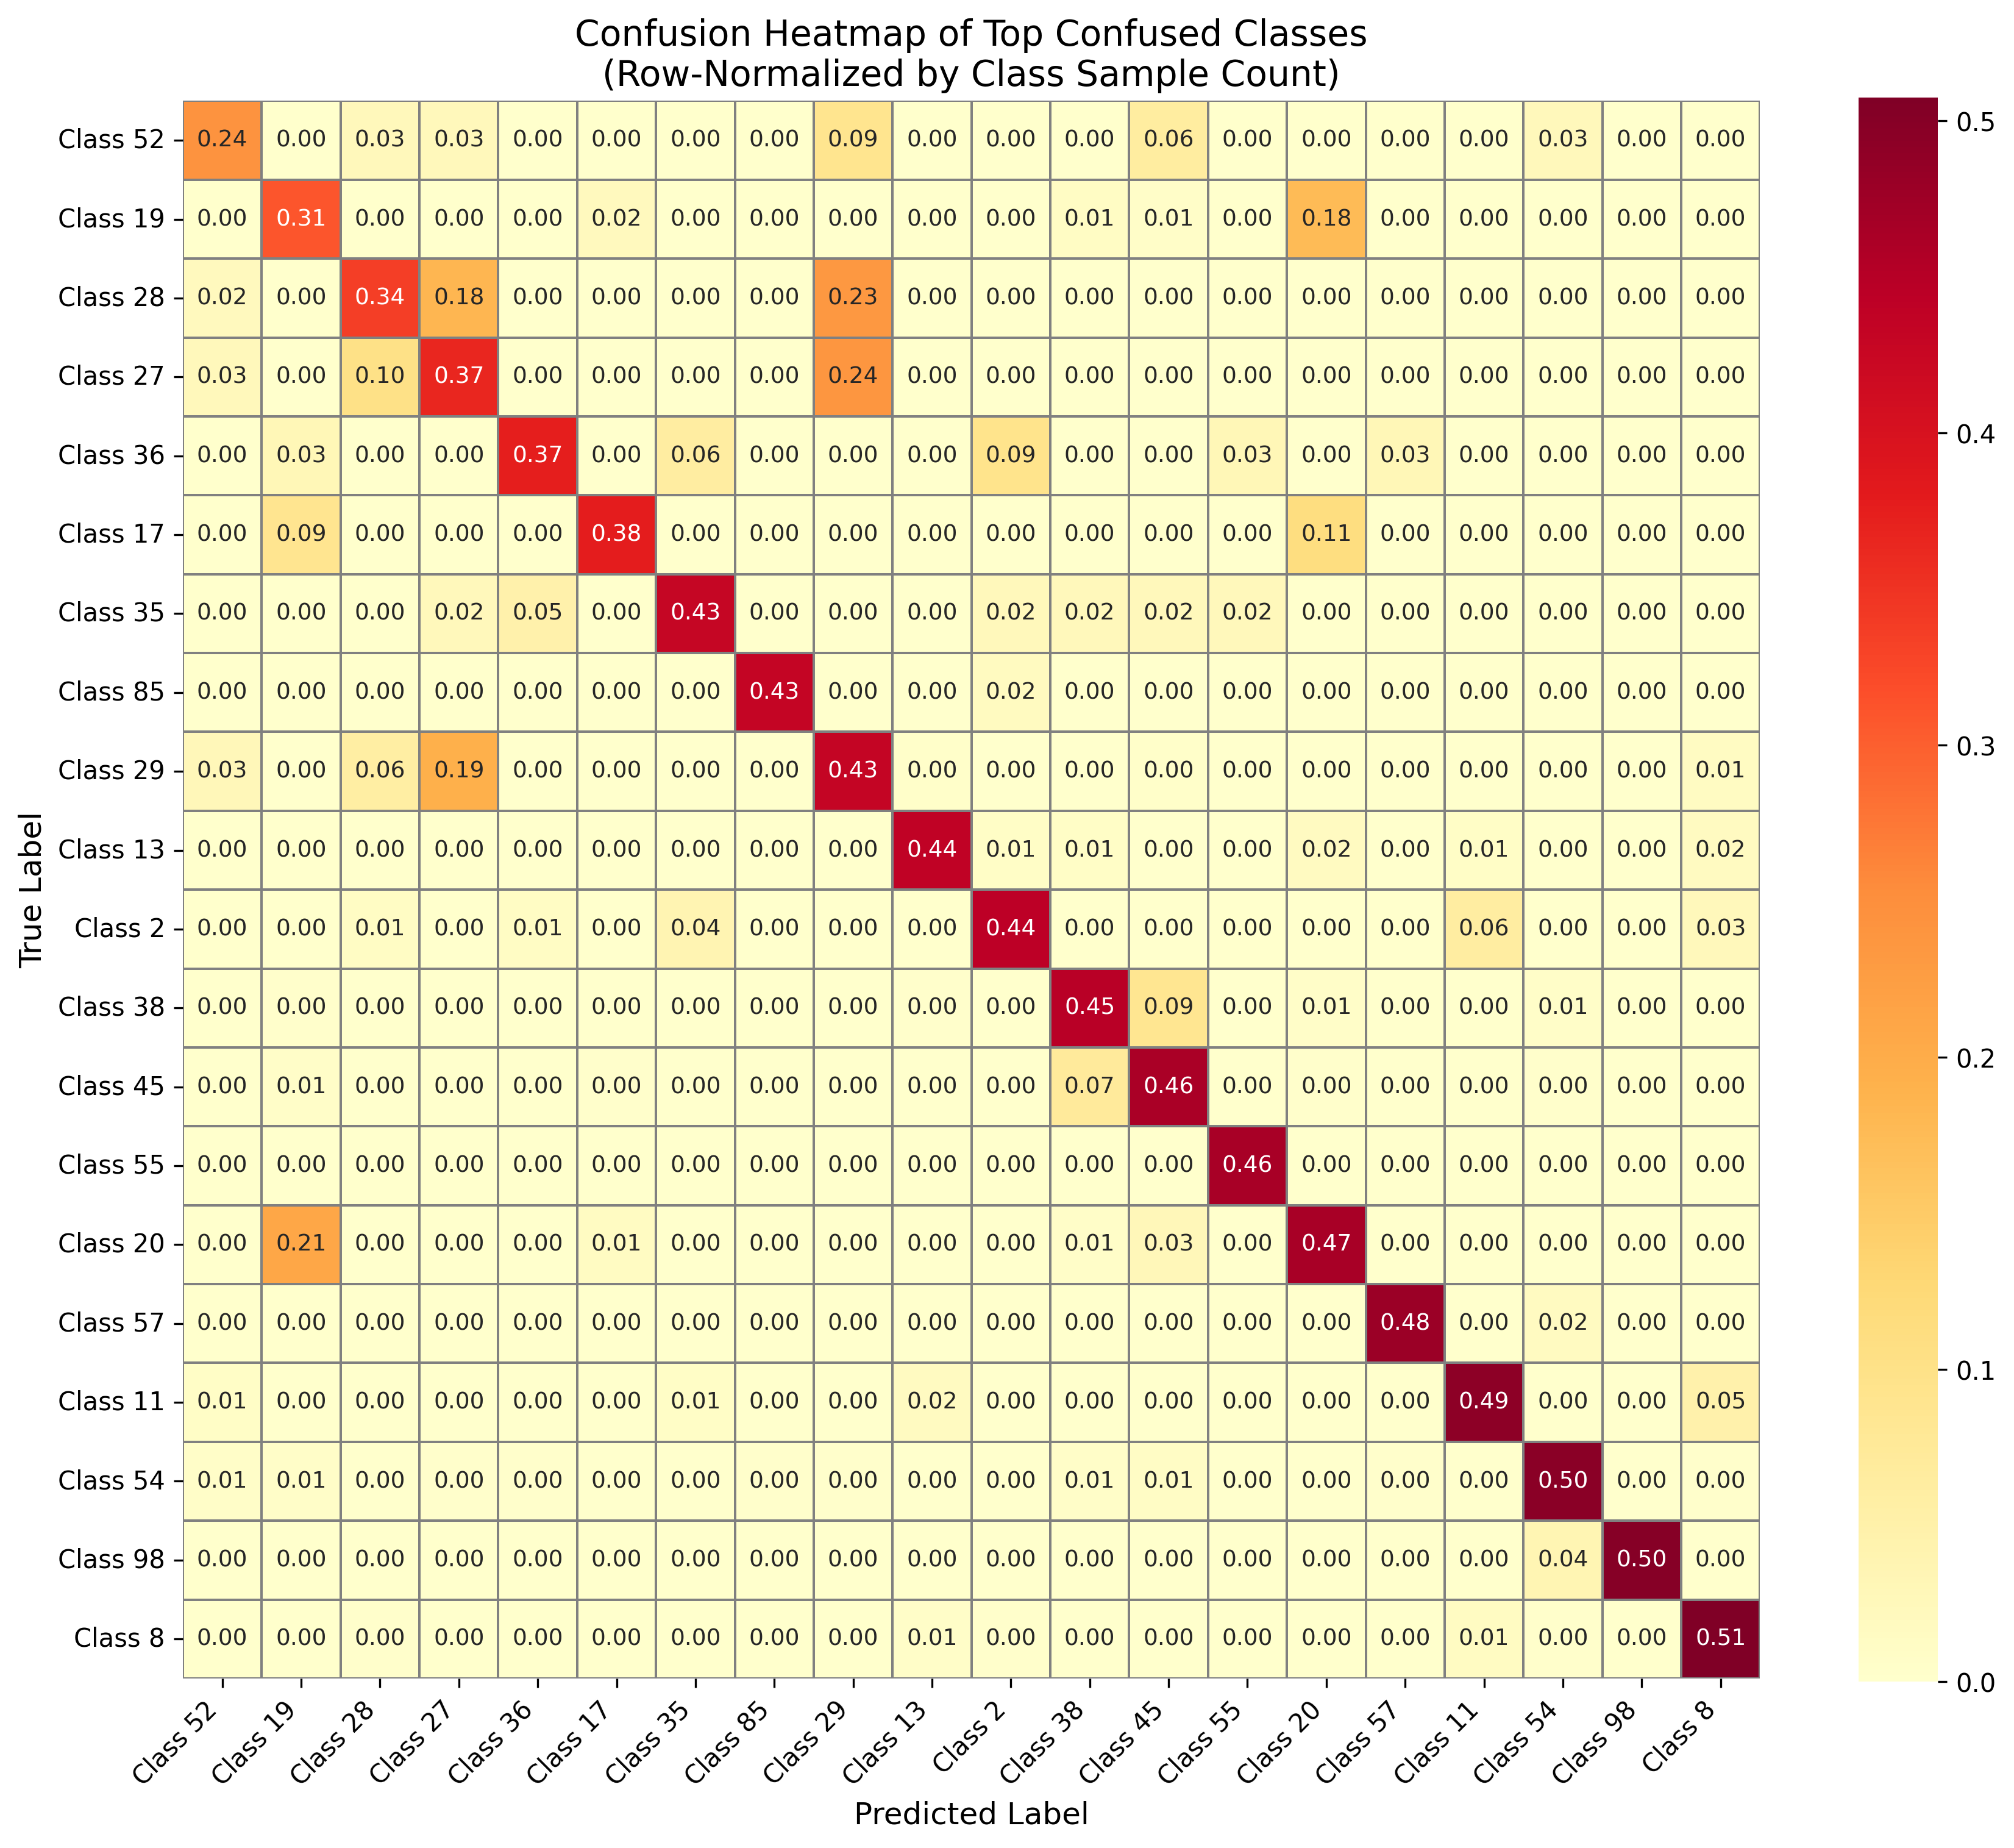

The normalized confusion matrix highlights that certain classes—such as Class 52, Class 19, and Class 28—are often misclassified, as indicated by their low diagonal values and higher off-diagonal proportions. This shows that the model struggles to distinguish these categories from others, despite normalization removing class size bias. The high confusion concentration across specific class pairs suggests the need for enhanced feature separation or class-level attention refinement.



## Lowest Accuracy Result

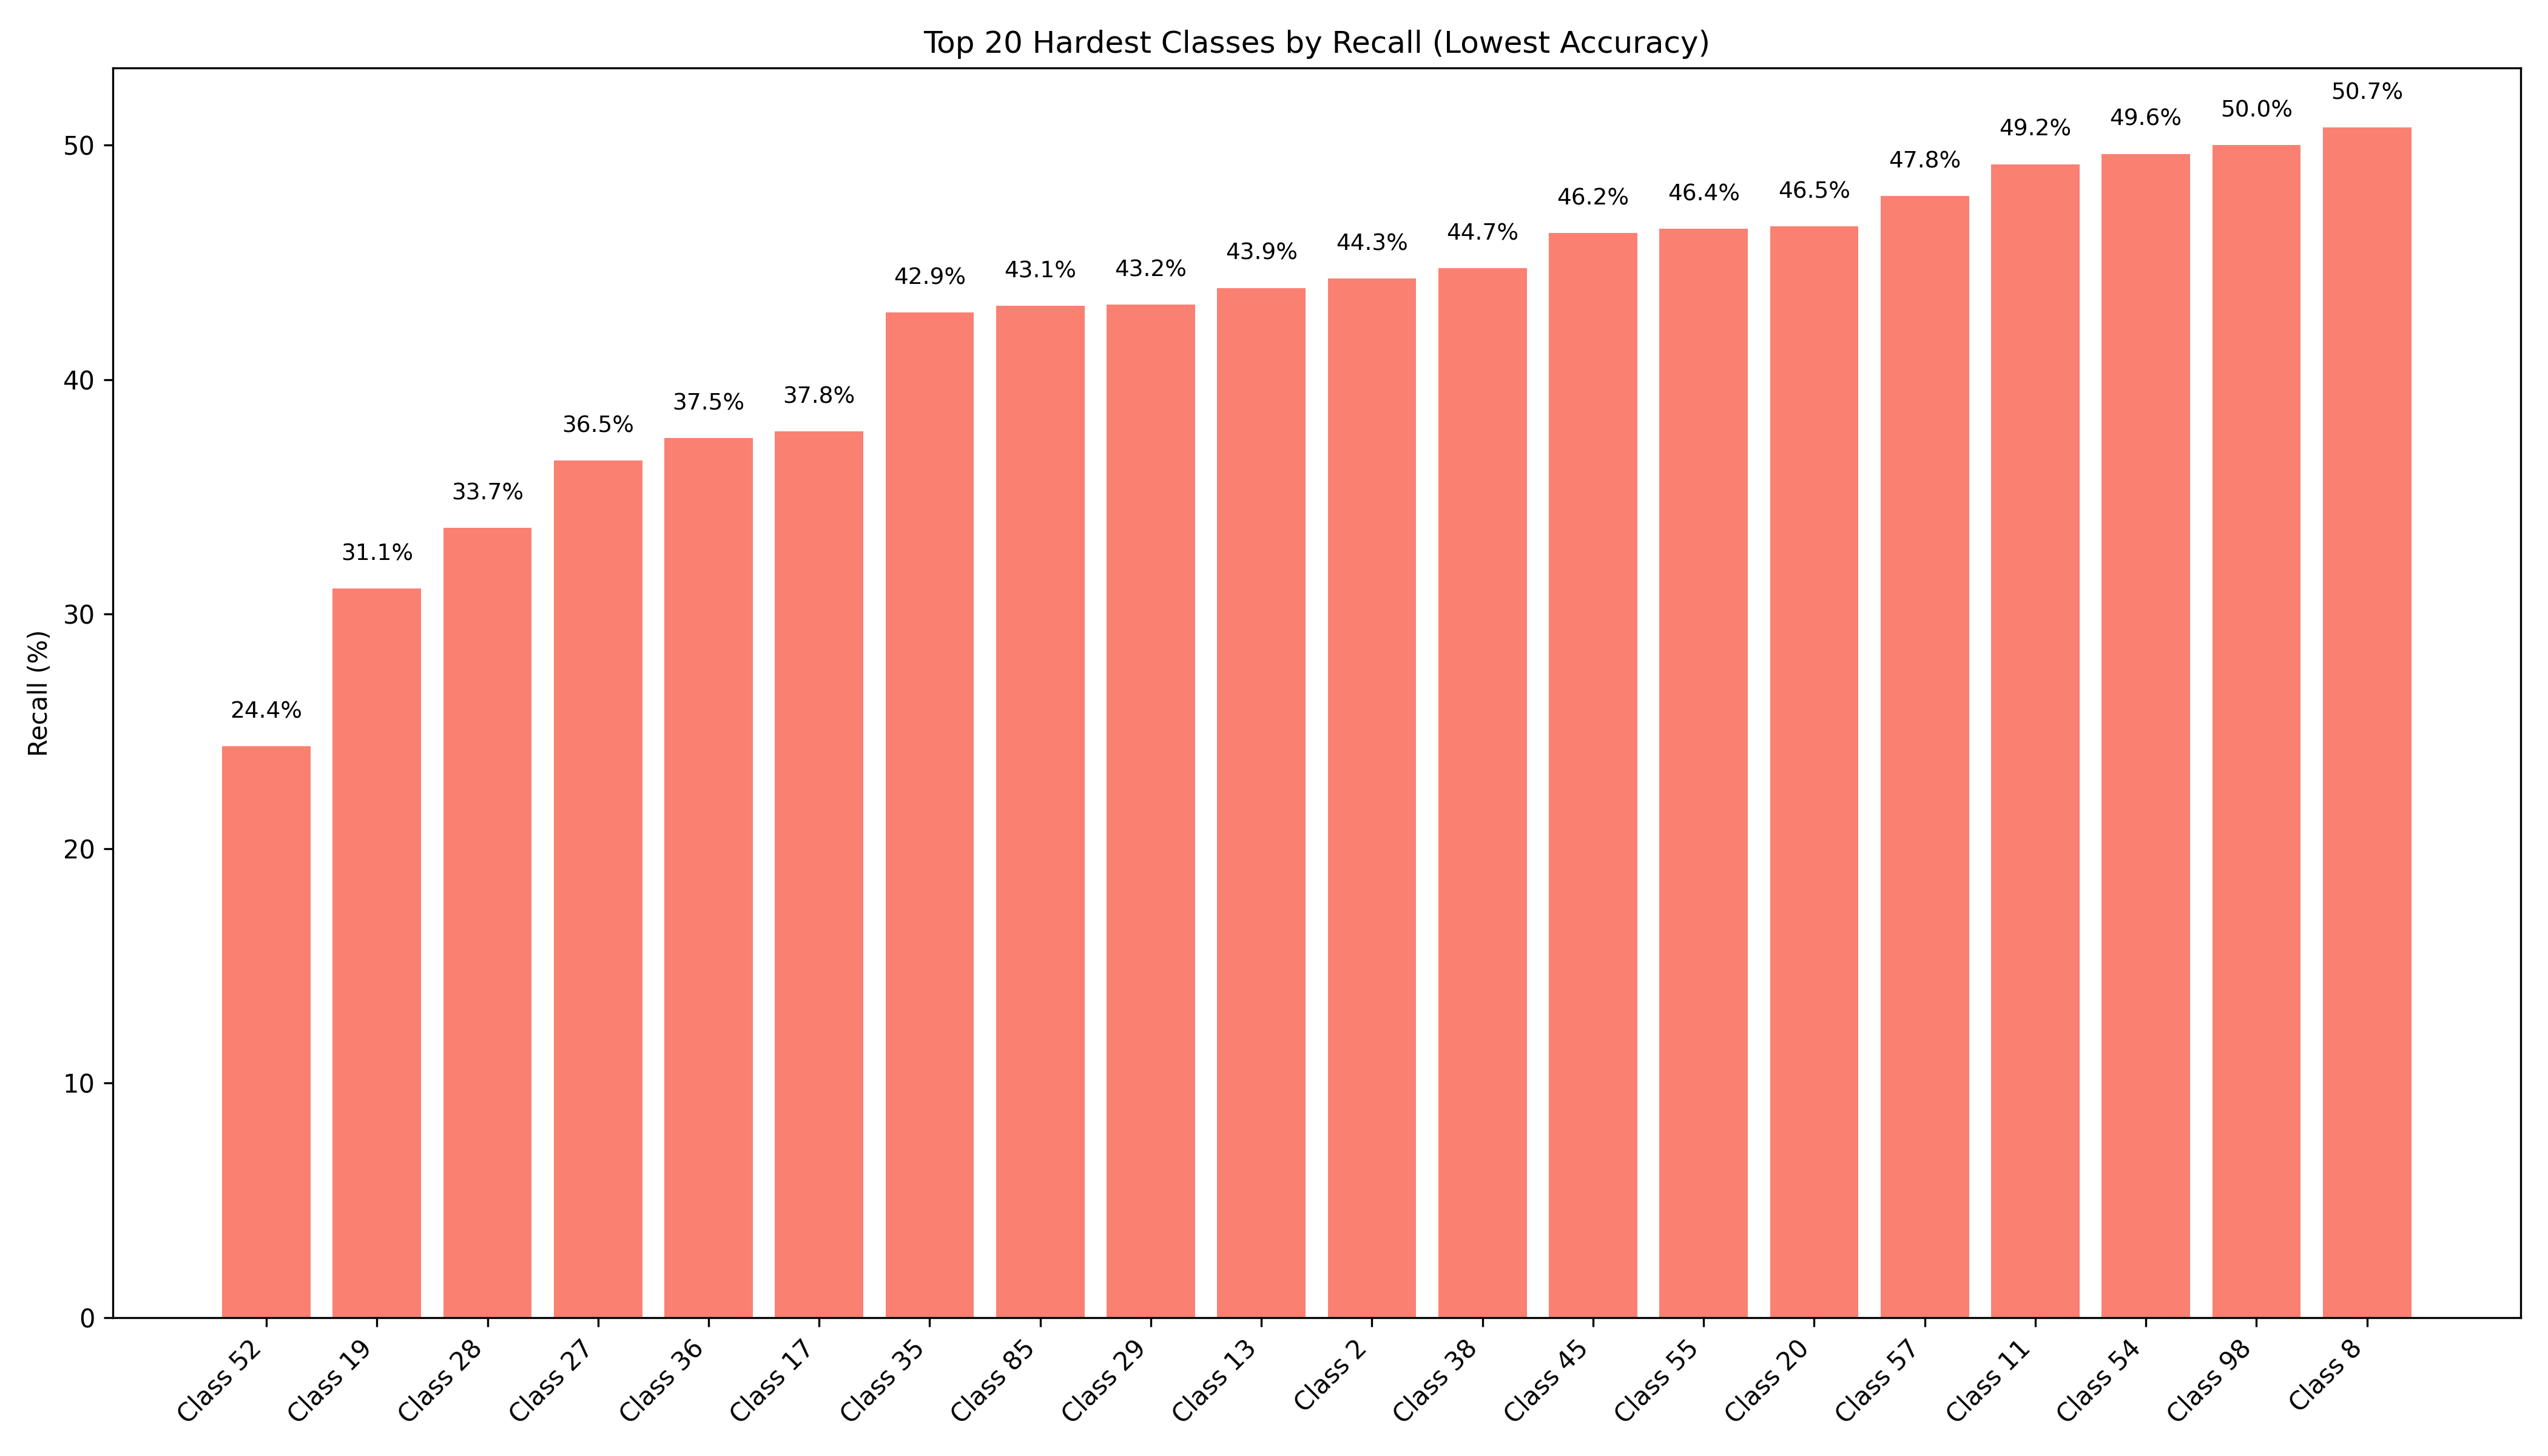

The bar chart above shows the 20 classes with the lowest recall scores. Class 52, with only 24.4% recall, represents the most challenging category for the model. Across these classes, the model correctly identifies fewer than 50% of true samples, indicating significant difficulty in distinguishing them from visually similar classes.




These classes may:

Have low sample counts (only 156 pictures in class 52 and 294 pictures in class 19)

Share high visual similarity with other insect types

Exhibit complex backgrounds or inconsistent lighting in images


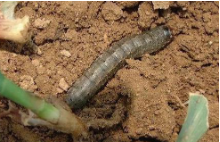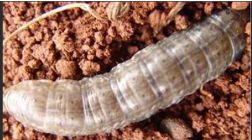

The detailed compare: left picure is from class 19 and right picture is from class 20

We found that these two pictures have similar body size, shape, color and background color. This leads to the model hard to classify these two classes.

## Loss value Result

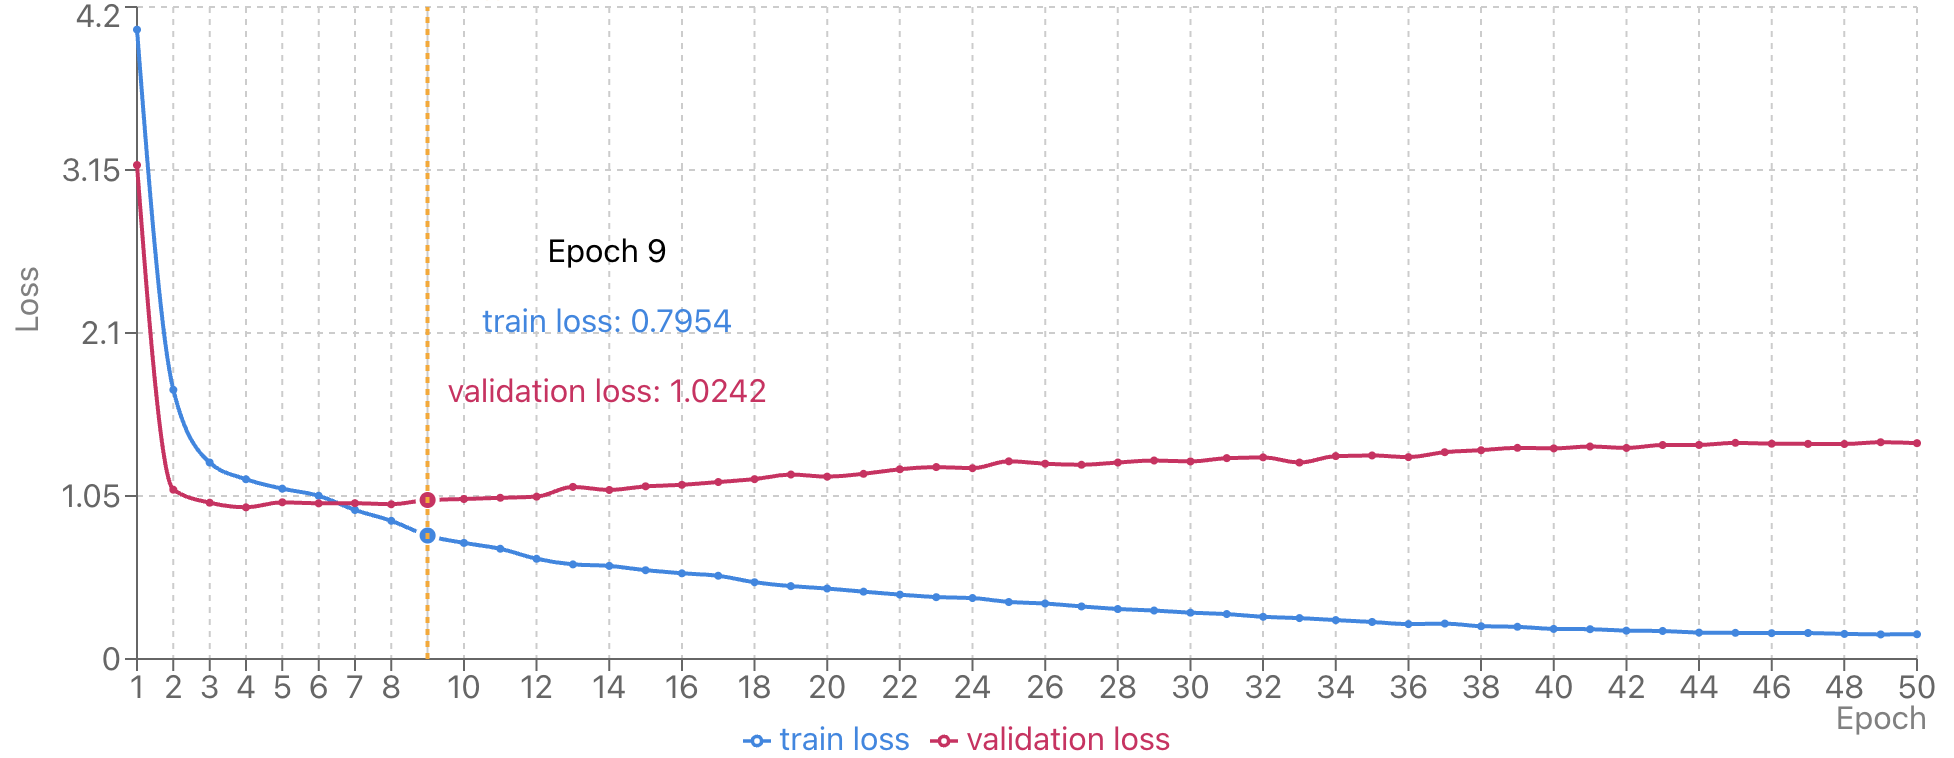

The training and validation loss curves indicate that the model effectively learned useful patterns during the early epochs. The validation loss reached its minimum at epoch 9 (val loss = 1.0242), after which it plateaued and slightly increased. This suggests that the model began to overfit beyond this point, continuing to improve on the training set while failing to generalize better on the validation data. A potential improvement could be applying early stopping at epoch 9 to preserve optimal generalization performance.



## Validation Accuracy Result

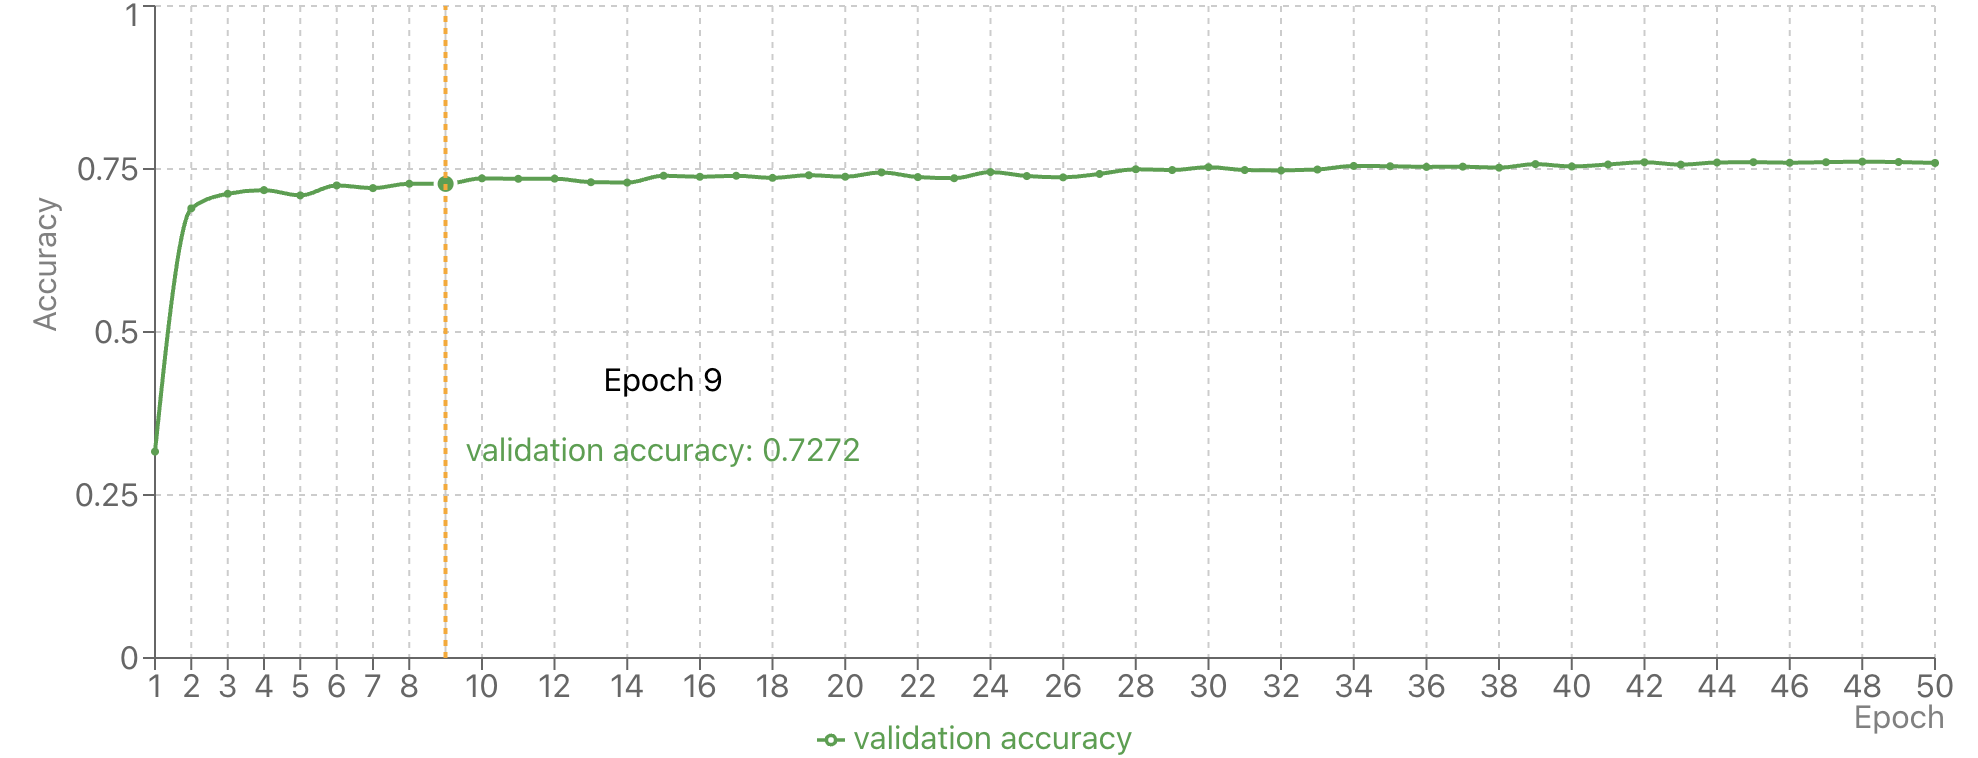

The validation accuracy curve indicates that the model achieved its peak performance at epoch 9, reaching an accuracy of 72.72%. After this point, validation accuracy remained nearly flat, showing no significant improvement despite further reductions in training loss. This suggests that the model converged early, and additional training likely led to overfitting without meaningful gains in generalization. The best-performing model checkpoint should therefore be selected from epoch 9.



# <a name="section-8"></a>Analysis

The final combined model achieved a commendable Accuracy of 76.1% and an excellent Macro-AUC of 98.5%. The Precision (71.0%), Recall (68.7%), and F1-score (69.6%) indicate a reasonably balanced classification performance across the 102 classes.



The integrated model illustrates significantly outperforms performance across all metrics. Its high precision (0.71) and recall (0.69) show reliable and comprehensive positive class predictions; the F1-score (0.70) and accuracy (0.76) confirm strong overall performance; and the M_AUC (0.99) underscores its superior classification capability. The success of the integrated model validates the effectiveness of the fusion strategy for this task.

## System Performance Insights

### Strenghts

*   Effective Synergy: The results strongly validate the hypothesis that combining Swin Transformer and ResNet can be beneficial. The significant gains in both accuracy and AUC compared to individual runs highlight the successful leveraging of complementary strengths.


*   Excellent Class Separability: The outstanding M_AUC demonstrates the model's strong capability in distinguishing between the fine-grained insect classes based on its output scores.

### Weaknesses & Limitations:

*   Gap to State-of-the-Art Accuracy: Despite the high AUC and improvement, the 76.1% accuracy indicates that nearly a quarter of the images are still misclassified, and there is a noticeable gap compared to top benchmark scores on IP102.
*   Complexity vs. Benefit: The combined model is inherently more complex than
using a single backbone. While the performance gains are significant compared to the presumed non-pretrained baselines, the question remains whether this combined model would outperform a single, well-tuned, state-of-the-art pre-trained model (e.g., Swin-B or ConvNeXt-B).

### Possible future work


* Optimize fine-tuning

  experiment further with learning rates,  optimizers , weight decay, and regularization specifically for the combined architecture or its fine-tuned components.
* Advanced Augmentation

  Implement state-of-the-art data augmentation (RandAugment, AutoAugment) and potentially stronger regularization techniques during fine-tuning.
